В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/mariia-honcharenko/python_for_DS_tasks.git

Cloning into 'python_for_DS_tasks'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 108 (delta 53), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (108/108), 6.32 MiB | 5.92 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [4]:
import sys
sys.path.append('/content/python_for_DS_tasks')

In [5]:
from process_bank_churn import preprocess_data

In [6]:
raw_df = pd.read_csv('/content/drive/MyDrive/Data Science/train.csv', index_col=0)

In [7]:
X_train, train_targets, X_val, val_targets, input_cols, scaler, encoder = preprocess_data(raw_df, scale_numeric=True)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
id,,,,,,,,,,,,,
7180,0.599045,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.603819,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.653938,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.568019,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.658711,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [9]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [10]:
from sklearn.metrics import roc_auc_score

train_preds = knn.predict_proba(X_train)[:, 1]

val_preds = knn.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f'Train AUC: {train_auc}')
print(f'Validation AUC: {val_auc}')


Train AUC: 0.9559428457733543
Validation AUC: 0.852585568283147


**Висновок**: Результати показують, що модель добре працює на тренувальних даних (AUC = 0.955), але трохи гірше на валідаційних (AUC = 0.85). Validation AUC є достатньо високим, що свідчить про те, що модель загалом добре узагальнює на невидимих даних, але є певна різниця між Train AUC і Validation AUC, що може свідчити про те, що модель трохи перенавчилася (high variance). Однак, ця різниця не є дуже великою, тому перенавчання не є серйозним, модель хороша але є можливість покращити.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [11]:
knn_2 = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [12]:
knn_best = knn_gs.best_estimator_

print(knn_gs.best_params_, knn_gs.best_score_)

{'n_neighbors': 9} 0.8671666666666666


In [13]:
train_preds_2 = knn_best.predict_proba(X_train)[:, 1]

val_preds_2 = knn_best.predict_proba(X_val)[:, 1]

train_auc_2 = roc_auc_score(train_targets, train_preds_2)
val_auc_2 = roc_auc_score(val_targets, val_preds_2)

print(f'Train AUC: {train_auc_2}')
print(f'Validation AUC: {val_auc_2}')

Train AUC: 0.9407278147861952
Validation AUC: 0.8808731737430551


**Висновок:**  Val AUC дещо покращився порівняно з попереднім результатом,
Результати при застосуванні моделі DecisionTree  були трохи кращими.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [14]:
import time
from sklearn.tree import DecisionTreeClassifier

In [15]:
random_seed = 42
dtc = DecisionTreeClassifier(random_state=random_seed)


param_grid = {
    'max_depth': np.arange(1, 21, 2),
    'max_leaf_nodes': np.arange(2, 11, 1)
}

grid_search = GridSearchCV(dtc, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)


start_time = time.time()
grid_search.fit(X_train, train_targets)
end_time = time.time()

execution_time = end_time - start_time

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Execution Time: {execution_time} seconds")
print(f"Best Parameters: {best_params}")
print(f"Best ROC AUC Score: {best_score}")

Execution Time: 14.037753105163574 seconds
Best Parameters: {'max_depth': 5, 'max_leaf_nodes': 10}
Best ROC AUC Score: 0.9013929183420709


In [16]:
dt_best = grid_search.best_estimator_


train_preds = dt_best.predict_proba(X_train)[:, 1]
val_preds = dt_best.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f"Train ROC AUC: {train_auc}")
print(f"Validation ROC AUC: {val_auc}")


Train ROC AUC: 0.9014754782174744
Validation ROC AUC: 0.9002184649152891


**Висновок**: якість моделі достатньо висока як на тренувальних, так і на валідаційних даних. Якщо порівняти ту модель яку я отрмала в попередній дз ( 'Max Depth': 6, 'Train AUC': 0.9321867224860289, 'Validation AUC': 0.9199790479150028) то отримані значення трошки нижче.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [17]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

In [19]:
random_seed = 42
dtc_2 = DecisionTreeClassifier(random_state=random_seed)

params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    dtc_2,
    params_dt,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=random_seed,
    n_iter=40,
    verbose=1
)

random_search.fit(X_train, train_targets)
print(random_search.best_estimator_)



Fitting 3 folds for each of 40 candidates, totalling 120 fits
DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=42)


In [20]:
dt_random_search_best = random_search.best_estimator_

train_preds = dt_random_search_best.predict_proba(X_train)[:, 1]
val_preds = dt_random_search_best.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)


best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best ROC AUC Score (cross-validated): {best_score}")
print(f"Train ROC AUC: {train_auc}")
print(f"Validation ROC AUC: {val_auc}")

Best Parameters: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}
Best ROC AUC Score (cross-validated): 0.910864318350194
Train ROC AUC: 0.9169275635848141
Validation ROC AUC: 0.9166204815145071


**Висновок:**  Якість моделі покращилась як на тренувальних так і на валідаційних даних. Найкращі параметри відрізняються в *попередній модел*і ( Best Parameters: {'max_depth': 5, 'max_leaf_nodes': 10}) та *теперішній*: Best Parameters: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [21]:
from process_bank_churn import preprocess_new_data

In [22]:
test_raw_df = pd.read_csv('/content/drive/MyDrive/Data Science/test.csv')
test_raw_df = test_raw_df.drop(columns=['id'])


In [23]:
X_test = preprocess_new_data(test_raw_df, input_cols, scaler, encoder, scale_numeric=False)

In [24]:
test_preds = dt_random_search_best.predict_proba(X_test)[:, 1]

In [25]:
submission_df = pd.DataFrame({'Id': test_raw_df.index, 'Exited': test_preds})

In [26]:
sample_submission_df=pd.read_csv('/content/drive/MyDrive/Data Science/sample_submission.csv')

In [27]:
sample_submission_df['Exited']=submission_df['Exited']

In [28]:
sample_submission_df.to_csv('submission_trees_search.csv', index=False)

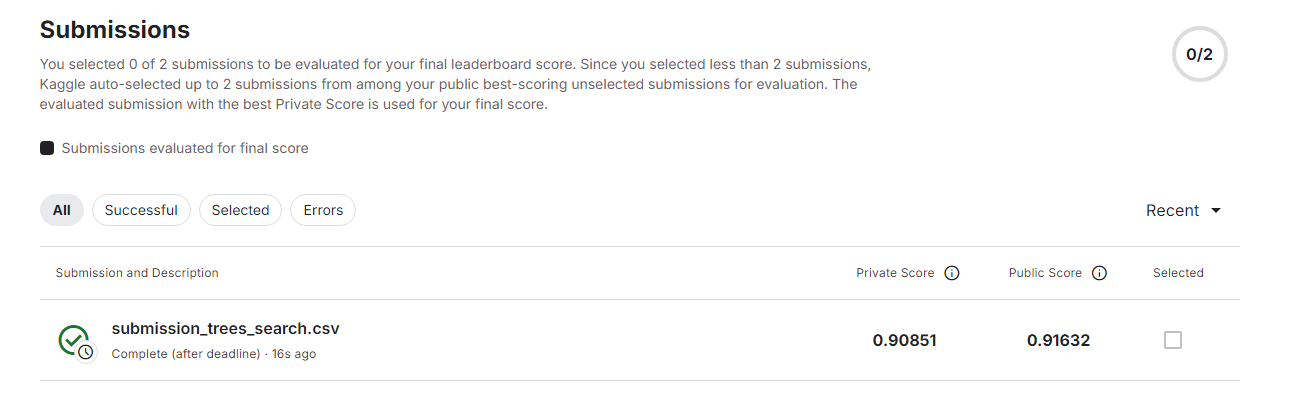